# Car Body Damage Detection
### -Detect scratch, dent, repaint etc. on car body

###1.3 Source/Useful Links

Data Preprocessing:
1. https://towardsdatascience.com/cnn-application-detecting-car-exterior-damage-full-implementable-code-1b205e3cb48c

2. https://www.analyticsvidhya.com/blog/2018/07/building-mask-r-cnn-model-detecting-damage-cars-python/

In [5]:
pip install mrcnn

     |████████████████████████████████| 61kB 2.2MB/s 
  Created wheel for mrcnn: filename=mrcnn-0.2-cp36-none-any.whl size=54931 sha256=4e8fece146d7d714b7ab6bdcd4475b286c8012818264470f6a8ff1e341ce6485
  Stored in directory: /root/.cache/pip/wheels/11/ed/28/e550ddc897c04c336b923eae4eb35c9aae993d20ce39d9cc40
Successfully built mrcnn


In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import json
from datetime import datetime
import numpy as np
import skimage.draw
import cv2
import math
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob
import itertools
import logging
import re
import random
from collections import OrderedDict
from PIL import Image
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from random import random
from random import seed
from keras import backend as K

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines

from matplotlib.patches import Polygon
from mrcnn.visualize import display_instances
from mrcnn.config import Config
from mrcnn import model as modellib, utils

import keras
import tensorflow as tf
from keras.layers import Input,Flatten,Conv2DTranspose,concatenate, Embedding, GlobalAveragePooling2D, MaxPooling2D, Activation, Dense, Conv2D, BatchNormalization, Dropout
from keras import layers
from keras import optimizers
from keras.models import Sequential, Model, load_model
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, Input
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras import initializers

# Root directory of the project
ROOT_DIR = os.path.abspath("/content/drive/My Drive/Colab Notebooks/CS2/references/")
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

## Data Preprocessing

In [0]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("damage", 1, "damage")

        # Train or validation dataset?
        dataset_dir = os.path.join(dataset_dir)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        annotations1 = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        # print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions'].values()]

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "damage",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "damage":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

In [0]:
# We need a function to convert EncodedPixels into mask
# https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode

def rle2mask(mask_rle, shape=(450,300)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    This function is specific to this competition

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    This function is specific to this competition
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [23]:
# Load dataset
dataset = CustomDataset()
dataset.load_custom(ROOT_DIR + "/train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 49
Class Count: 2
  0. BG                                                
  1. damage                                            


In [0]:
def get_masks(mask, class_ids, class_names, limit=1):
    """Display the given image and the top few class masks."""
    to_display = []
    unique_class_ids = np.unique(class_ids)
    mask_area = [np.sum(mask[:, :, np.where(class_ids == i)[0]])
                 for i in unique_class_ids]
    top_ids = [v[0] for v in sorted(zip(unique_class_ids, mask_area),
                                    key=lambda r: r[1], reverse=True) if v[1] > 0]
    # Generate images and titles
    for i in range(limit):
        class_id = top_ids[i] if i < len(top_ids) else -1
        # Pull masks of instances belonging to the same class.
        m = mask[:, :, np.where(class_ids == class_id)[0]]
        m = np.sum(m * np.arange(1, m.shape[-1] + 1), -1)
    return m

In [0]:
# Get image file names from json file 
annotations1 = json.load(open(os.path.join(ROOT_DIR +'/train/', "via_region_data.json")))
annotations = list(annotations1.values())  # don't need the dict keys

# The VIA tool saves images in the JSON even if they don't have any
# annotations. Skip unannotated images.
annotations = [a for a in annotations if a['regions']]
train_image_names = []
for a in annotations:
    train_image_names.append(a['filename'])

### Create EncodedPixels CSV file from annotated file

In [0]:
train_data = pd.DataFrame()
for image_id, name in enumerate(train_image_names):
    mask, class_ids = dataset.load_mask(image_id)
    msk = get_masks(mask, class_ids, dataset.class_names)
    EncodedPixels = mask2rle(msk)
    x2 = pd.DataFrame({"ImageId":name, "EncodedPixels":[EncodedPixels]})
    train_data = pd.concat([train_data,x2], ignore_index=True)

In [40]:
train_data.head()

,ImageId,EncodedPixels
0,image67.jpg,77907 1 78425 1 78943 1 79461 1 79979 1 80497 ...
1,image66.jpg,20151 1 20373 47 20595 51 20816 56 21038 60 21...
2,image65.jpg,51421 1 51944 22 52467 44 52989 66 53524 76 54...
3,image64.jpg,206966 1 207375 7 207783 15 208191 23 208599 3...
4,image63.jpg,72538 1 72958 6 73378 11 73798 17 74218 22 746...


### Save masks as jpeg files extracted from json file

In [0]:
train_data = pd.DataFrame()
for image_id, name in enumerate(train_image_names):
    mask, class_ids = dataset.load_mask(image_id)
    msk = get_masks(mask, class_ids, dataset.class_names)
    img = msk.reshape((*msk.shape, 1)) #to make shape(m x n x 1)
    tf_img = tf.image.resize(img, [img.shape[0], img.shape[1]]) # Convert to tensor
    gray = tf.image.grayscale_to_rgb(tf_img, name=None) # Gray scale image
    image = tf.image.resize(gray, [256, 256]) # Resize
    tf.keras.preprocessing.image.save_img('mask_'+str(name), image)

Train. Validation and Test split

In [0]:
X = train_data.copy()
X_train, X_test = train_test_split(X, test_size = 0.1, random_state=42)
X_train, X_val = train_test_split(X_train, test_size = 0.2, random_state=42)
print(X_train.shape, X_val.shape, X_test.shape)

(35, 2) (9, 2) (5, 2)


In [0]:
X_train.head()

,ImageId,EncodedPixels
31,image21.jpeg,13466 1 13659 3 13852 5 14045 7 14238 9 14431 ...
4,image63.jpg,72538 1 72958 6 73378 11 73798 17 74218 22 746...
1,image66.jpg,20151 1 20373 47 20595 51 20816 56 21038 60 21...
35,image16.jpg,184190 1 184760 7 185330 13 185900 19 186470 2...
30,image28.jpg,165656 1 166188 1 166720 1 167251 2 167783 3 1...


## Exploratory Data Analysis

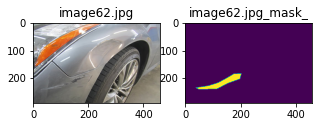

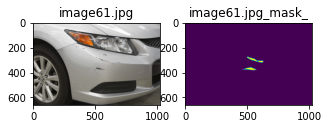

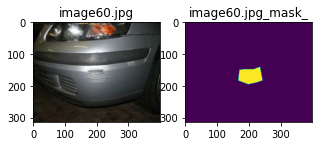

--------------------------------------------------------------------------------


In [0]:
# Visualization: Sample i
cnt = 0
for i in train_data[['ImageId','EncodedPixels']][5:15].values:
    if cnt<3:
            fig, (ax1,ax2) = plt.subplots(nrows = 1,ncols = 2,figsize=(5, 2))
            img = Image.open(str(ROOT_DIR +'/train/'+ i[0]))
            ax1.imshow(img)
            ax1.set_title(i[0])
            cnt+=1
            img = cv2.imread(str(ROOT_DIR +'/train/'+  i[0]), cv2.IMREAD_UNCHANGED)
            ax2.imshow(rle2mask(i[1], shape=((img.shape[1], img.shape[0]))))
            ax2.set_title(i[0]+'_mask_')
            a = rle2mask(i[1])
            plt.show()
print('-'*80)

area' as a new feature

,EncodedPixels
count,35.000000
mean,29863.742857
std,57547.544424
min,1573.000000
25%,3962.000000
50%,7508.000000
75%,27810.000000
max,316984.000000


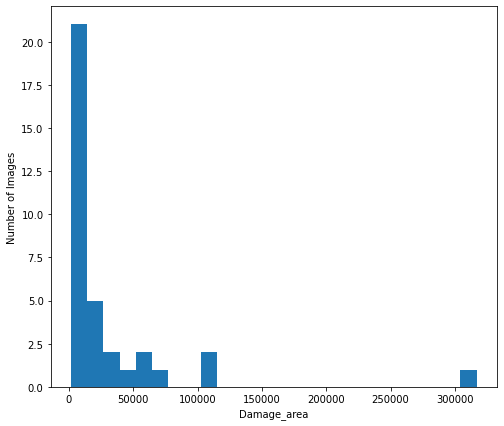

In [0]:
fig, ax = plt.subplots(1,1,figsize=(8, 7))
tmp = X_train['EncodedPixels'].apply(lambda s: sum([int(k) for k in s.split(' ')[1::2]]))
ax.hist(tmp.values,bins = 25)
ax.set_xlabel('Damage_area')
ax.set_ylabel('Number of Images')

tmp = X_train['EncodedPixels'].apply(lambda s: sum([int(k) for k in s.split(' ')[1::2]])).describe()
area_df = pd.DataFrame(tmp)
area_df